<a href="https://colab.research.google.com/github/Abdul-Hayee11/LAB--3/blob/main/Copy_of_basic_OOK_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/basic_OOK_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate a basic OOK transmission system

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

fatal: destination path 'OptiCommPy' already exists and is not an empty directory.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
  Created wheel for OptiCommPy: filename=OptiCommPy-0.9.0-py3-none-any.whl size=81361 sha256=66c9b1cb85ff304895587949cb7d9679f21dd10953c683fb201d99e1b30e3172
  Stored in directory: /tmp/pip-ephem-wheel-cache-kvsrwcp5/wheels/0a/b3/b4/c1f785c2fbf2de32a986f34e6d5146d854df27f3012a7f465d
Successfully built OptiCommPy
  Attempting uninstall: OptiCommPy
    Found existing installation: OptiCommPy 0.9.0
    Uninstalling OptiCommPy-0.9.0:
      Successfully uninstalled OptiCommPy-0.9.0


In [2]:
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, lowPassFIR, pnorm, signal_power

try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
np.random.seed(seed=123) # fixing the seed to get reproducible results

### Intensity modulation (IM) with On-Off Keying (OOK)

Average power of the modulated optical signal [mW]: 0.498 mW
Average power of the modulated optical signal [dBm]: -3.026 dBm


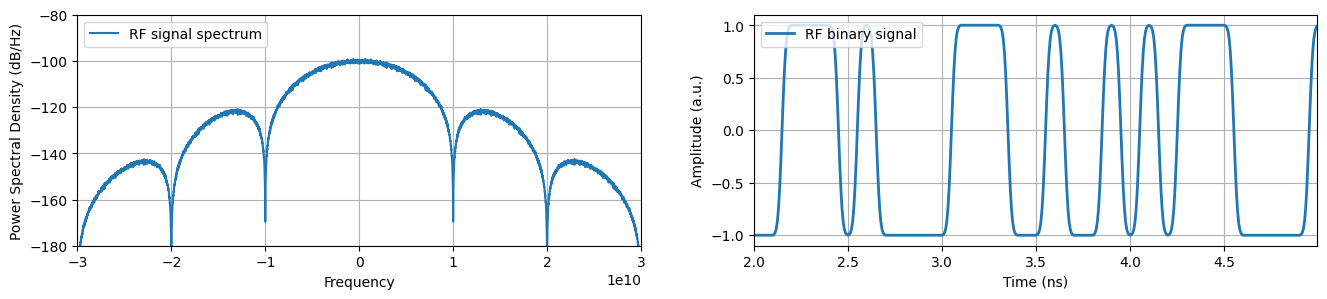

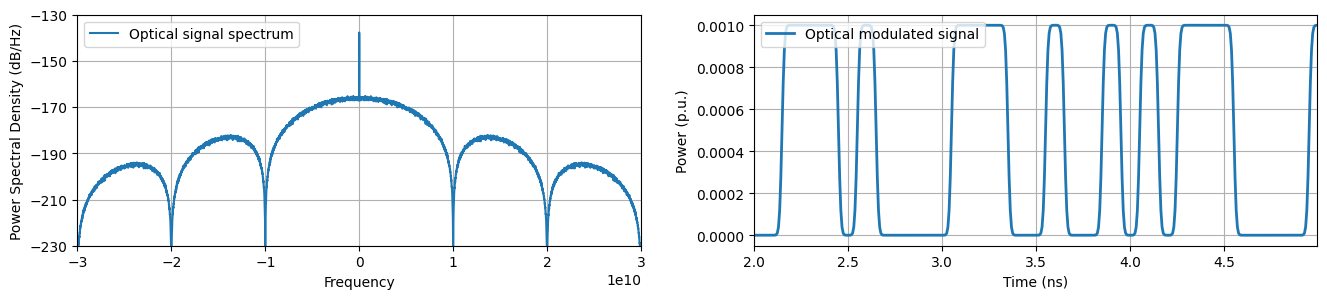

In [6]:
# simulation parameters
SpS = 16     # samples per symbol
M = 2        # order of the modulation format
Rs = 10e9    # Symbol rate (for OOK case Rs = Rb)
Fs = Rs*SpS  # Sampling frequency
Ts = 1/Fs    # Sampling period

# Laser power
Pi_dBm = 0         # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm) # convert from dBm to W

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=100000)

# generate 2-PAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, sigTx, paramMZM)

print('Average power of the modulated optical signal [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50)
t = interval*Ts/1e-9

# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'RF signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, sigTx[interval], label = 'RF binary signal', linewidth=2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-230,-130);
axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

### Linear fiber channel model (fiber + EDFA opt. amplifier)

In [7]:
# linear optical channel
paramCh = parameters()
paramCh.L = 100         # total link distance [km]
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

sigCh = linearFiberChannel(sigTxo, paramCh)

# receiver pre-amplifier
paramEDFA = parameters()
paramEDFA.G = paramCh.α*paramCh.L    # edfa gain
paramEDFA.NF = 4.5   # edfa noise figure
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

sigCh = edfa(sigCh, paramEDFA)

### Direct-detection (DD) pin receiver model

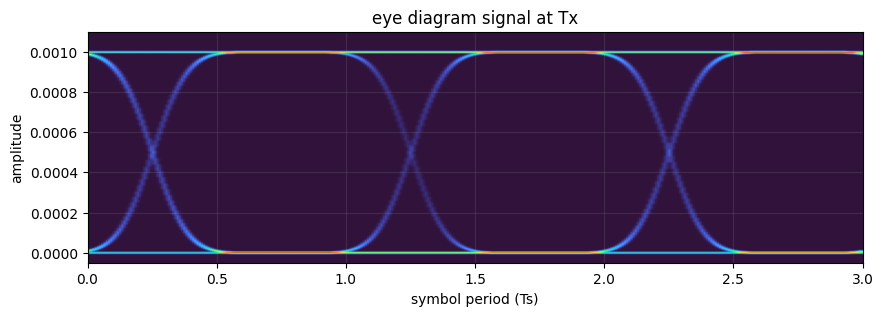

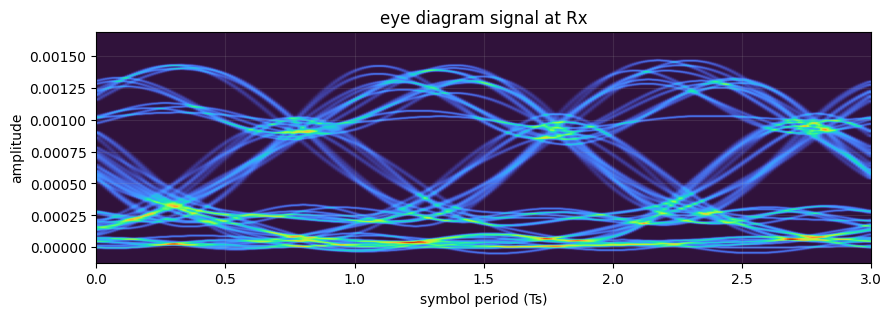

In [8]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
paramPD.Fs = Fs

I_Tx = photodiode(sigTxo.real, paramPD) # transmitted signal

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs
paramPD.ipd_sat = 5e-3

I_Rx = photodiode(sigCh, paramPD) # received signal after fiber channel and non-ideal PD

discard = 100
eyediagram(I_Tx[discard:-discard], I_Tx.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard], I_Rx.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I0 = 0.23 
I1 = 2.13 
σ0 = 0.22 
σ1 = 0.15 
Optimal decision threshold Id = 1.37 
Q = 5.26 

Number of counted errors = 0 
BER = 0.00e+00 
Pb = 7.10e-08 


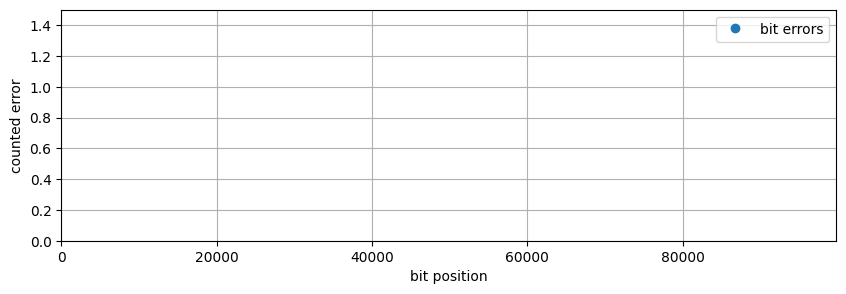

In [9]:
I_Rx = I_Rx/np.std(I_Rx)

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS]

# get received signal statistics
I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx> Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size);

### Generate curve of BER vs receiver input power

In [10]:
# simulation parameters
SpS = 16        # Samples per symbol
M = 2           # order of the modulation format
Rs = 40e9       # Symbol rate (for the OOK case, Rs = Rb)
Fs = SpS*Rs     # Signal sampling frequency (samples/second)
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = 1.1*Rs
paramPD.Fs = Fs

powerValues = np.arange(-30,-14) # power values at the input of the pin receiver
BER = np.zeros(powerValues.shape)
Pb = np.zeros(powerValues.shape)

discard = 100
for indPi, Pi_dBm in enumerate(tqdm(powerValues)):

    Pi = dBm2W(Pi_dBm+3) # optical signal power in W at the MZM input

    # generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**6)
    n = np.arange(0, bitsTx.size)

    # generate ook modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx) # power normalization

    # upsampling
    symbolsUp = upsample(symbTx, SpS)

    # pulse formatting
    sigTx = firFilter(pulse, symbolsUp)

    # optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # pin receiver
    I_Rx = photodiode(sigTxo.real, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # capture samples in the middle of signaling intervals
    I_Rx = I_Rx[0::SpS]

    # get received signal statistics

    I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
    I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

    σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
    σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
    Q = (I1-I0)/(σ1 + σ0) # Q-factor

    # Aplica a regra de decisão ótima
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx>  Id] = 1
    bitsRx[I_Rx<= Id] = 0

    err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER[indPi] = np.mean(err)
    Pb[indPi] = 0.5*erfc(Q/np.sqrt(2)) # probability of bit error (theory)

  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-11-929d5377b018>:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(BER),'o',label='BER')


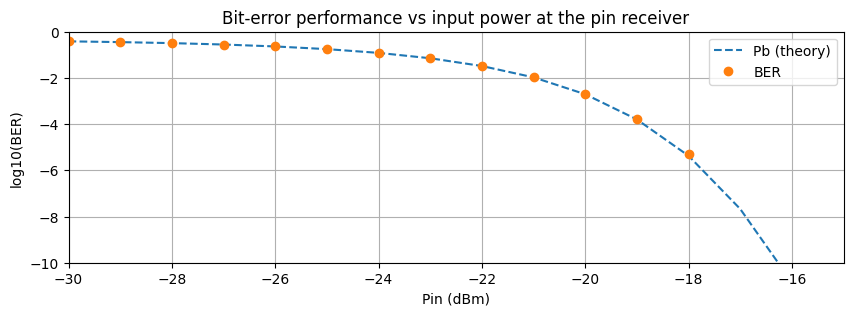

In [11]:
plt.figure()
plt.plot(powerValues, np.log10(Pb),'--',label='Pb (theory)')
plt.plot(powerValues, np.log10(BER),'o',label='BER')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Pin (dBm)');
plt.title('Bit-error performance vs input power at the pin receiver')
plt.legend();
plt.ylim(-10,0);
plt.xlim(min(powerValues), max(powerValues));

LENGTH 10-100KM

Analyzing dispersion:   0%|          | 0/11 [00:00<?, ?it/s]

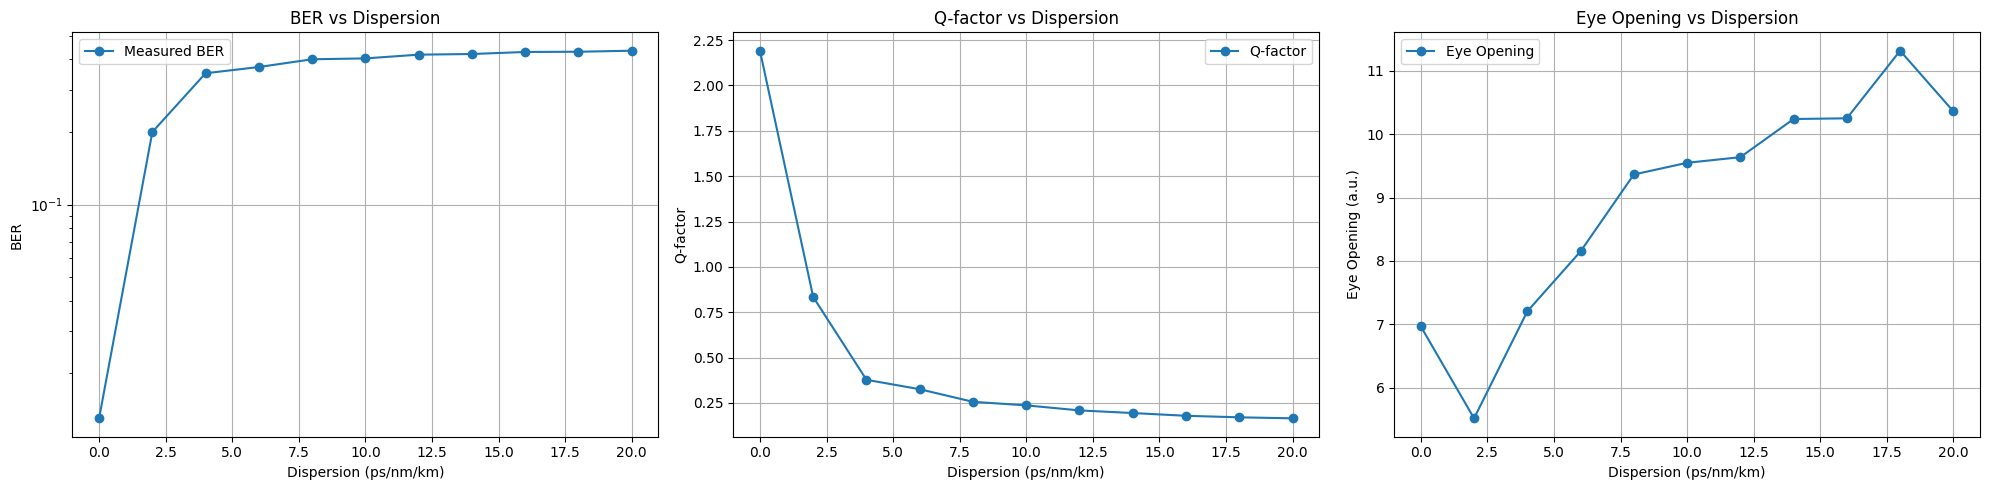


Numerical Results:
 Dispersion (ps/nm/km)      BER  Q-factor  Eye Opening
                   0.0 1.30e-02      2.19        6.965
                   2.0 2.00e-01      0.83        5.513
                   4.0 3.50e-01      0.38        7.203
                   6.0 3.72e-01      0.33        8.150
                   8.0 4.00e-01      0.26        9.364
                  10.0 4.04e-01      0.24        9.549
                  12.0 4.18e-01      0.21        9.638
                  14.0 4.21e-01      0.19       10.241
                  16.0 4.29e-01      0.18       10.252
                  18.0 4.30e-01      0.17       11.319
                  20.0 4.34e-01      0.17       10.361

Key Statistics:
Minimum BER: 1.30e-02 at 0.0 ps/nm/km
Maximum Q-factor: 2.19 at 0.0 ps/nm/km
Maximum Eye Opening: 11.319 at 18.0 ps/nm/km

No dispersion values achieve BER < 1e-03


In [15]:
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, lowPassFIR, pnorm, signal_power
try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter
from optic.utils import parameters, dBm2W
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import pandas as pd

# Simulation parameters
SpS = 16        # Samples per symbol
M = 2           # Order of the modulation format
Rs = 40e9       # Symbol rate
Fs = SpS*Rs     # Signal sampling frequency
Ts = 1/Fs       # Sampling period

# Define dispersion values to analyze
dispersion_values = np.linspace(0, 20, 11)  # 0 to 20 ps/nm/km
BER_vs_dispersion = np.zeros(dispersion_values.shape)
Q_factors = np.zeros(dispersion_values.shape)
eye_openings = np.zeros(dispersion_values.shape)

# Fixed parameters
Pi_dBm = -20
Pi = dBm2W(Pi_dBm + 3)
fixed_length = 80  # km

# Initialize parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# Channel parameters
paramCh = parameters()
paramCh.L = fixed_length
paramCh.α = 0.2
paramCh.Fc = 193.1e12
paramCh.Fs = Fs

# EDFA parameters
paramEDFA = parameters()
paramEDFA.NF = 4.5
paramEDFA.G = paramCh.α * fixed_length
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

# Pulse shaping
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

discard = 100
for ind, D in enumerate(tqdm(dispersion_values, desc="Analyzing dispersion")):
    # Update dispersion parameter
    paramCh.D = D

    # Generate bit sequence
    bitsTx = np.random.randint(2, size=10**6)

    # Generate modulated sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx)

    # Upsampling and pulse shaping
    symbolsUp = upsample(symbTx, SpS)
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Fiber propagation
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # EDFA amplification
    sigCh = edfa(sigCh, paramEDFA)

    # Photodetection
    paramPD = parameters()
    paramPD.ideal = False
    paramPD.B = Rs
    paramPD.Fs = Fs

    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Calculate eye opening
    eye_matrix = I_Rx[:-SpS].reshape(-1, SpS)
    eye_openings[ind] = np.abs(np.min(eye_matrix[bitsTx[:-1]==1]) -
                              np.max(eye_matrix[bitsTx[:-1]==0]))

    # Sample and calculate statistics
    I_Rx = I_Rx[0::SpS]
    I1 = np.mean(I_Rx[bitsTx==1])
    I0 = np.mean(I_Rx[bitsTx==0])
    σ1 = np.std(I_Rx[bitsTx==1])
    σ0 = np.std(I_Rx[bitsTx==0])

    # Calculate Q-factor and threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors[ind] = Q

    # Calculate BER
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx > Id] = 1
    bitsRx[I_Rx <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_vs_dispersion[ind] = np.mean(err)

# Create DataFrame for numerical results
results_df = pd.DataFrame({
    'Dispersion (ps/nm/km)': dispersion_values,
    'BER': BER_vs_dispersion,
    'Q-factor': Q_factors,
    'Eye Opening': eye_openings
})

# Format results
results_df['BER'] = results_df['BER'].apply(lambda x: f'{x:.2e}')
results_df['Q-factor'] = results_df['Q-factor'].round(2)
results_df['Eye Opening'] = results_df['Eye Opening'].round(3)

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# BER vs Dispersion
ax1.semilogy(dispersion_values, BER_vs_dispersion, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('Dispersion (ps/nm/km)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs Dispersion')
ax1.legend()

# Q-factor vs Dispersion
ax2.plot(dispersion_values, Q_factors, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('Dispersion (ps/nm/km)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs Dispersion')
ax2.legend()

# Eye Opening vs Dispersion
ax3.plot(dispersion_values, eye_openings, 'o-', label='Eye Opening')
ax3.grid(True)
ax3.set_xlabel('Dispersion (ps/nm/km)')
ax3.set_ylabel('Eye Opening (a.u.)')
ax3.set_title('Eye Opening vs Dispersion')
ax3.legend()

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print(results_df.to_string(index=False))

# Calculate and print key statistics
print("\nKey Statistics:")
print(f"Minimum BER: {min(BER_vs_dispersion):.2e} at {dispersion_values[np.argmin(BER_vs_dispersion)]} ps/nm/km")
print(f"Maximum Q-factor: {max(Q_factors):.2f} at {dispersion_values[np.argmax(Q_factors)]} ps/nm/km")
print(f"Maximum Eye Opening: {max(eye_openings):.3f} at {dispersion_values[np.argmax(eye_openings)]} ps/nm/km")

# Find maximum dispersion for acceptable performance
BER_threshold = 1e-3
acceptable_dispersion = dispersion_values[BER_vs_dispersion < BER_threshold]
if len(acceptable_dispersion) > 0:
    max_acceptable_dispersion = max(acceptable_dispersion)
    print(f"\nMaximum dispersion for BER < {BER_threshold:.0e}: {max_acceptable_dispersion:.1f} ps/nm/km")
else:
    print(f"\nNo dispersion values achieve BER < {BER_threshold:.0e}")

FIBER DESPERSION 0-20ps

Analyzing dispersion: 100%|██████████| 11/11 [01:32<00:00,  8.45s/it]


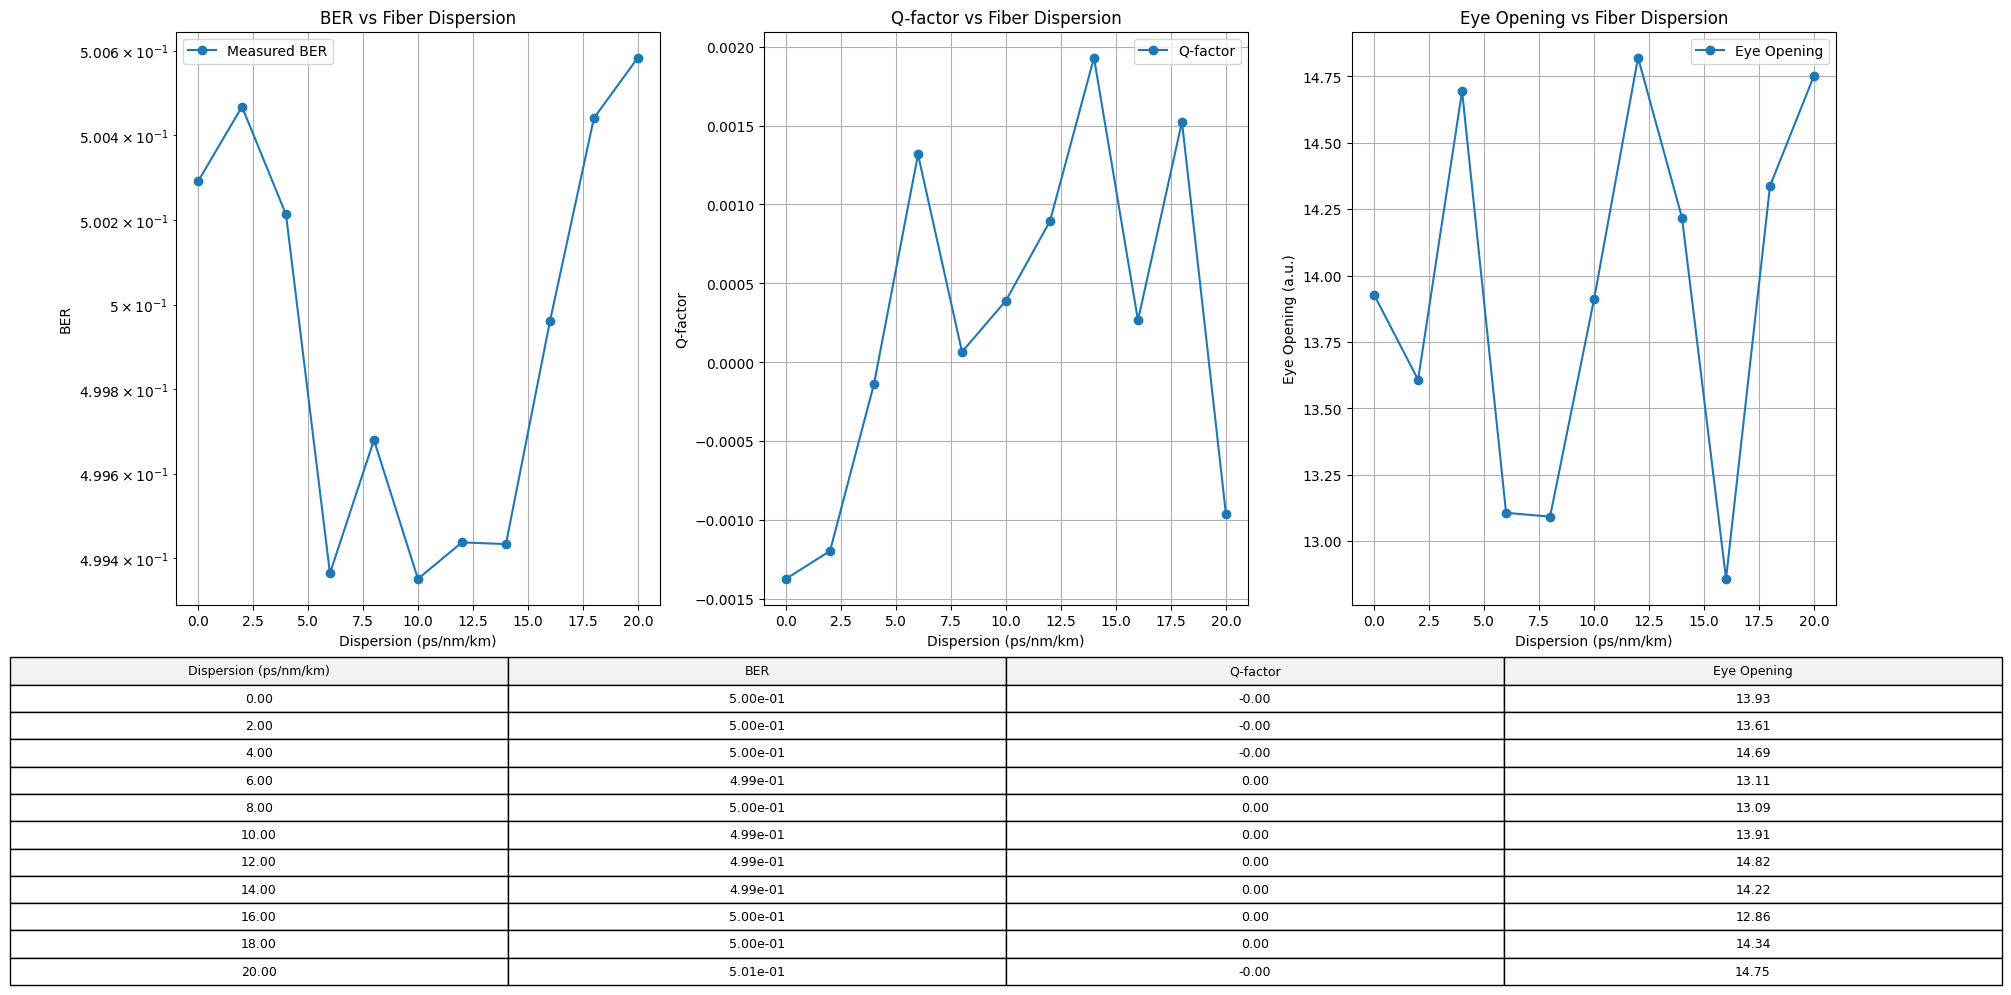


Key Findings:
Optimal dispersion value (lowest BER): 10.00 ps/nm/km
Minimum BER: 4.99e-01
Maximum Q-factor: 0.00
Maximum eye opening: 14.82


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from tqdm import tqdm

def dBm2W(dBm):
    """Convert power from dBm to Watts"""
    return 10**(dBm/10) / 1000

class Parameters:
    """Class to store various system parameters"""
    pass

def pulseShape(type, SpS):
    """Generate pulse shape"""
    if type.lower() == 'nrz':
        return np.ones(SpS)
    else:
        raise ValueError("Unsupported pulse shape type")

def pnorm(x):
    """Normalize power of signal"""
    return x/np.sqrt(np.mean(np.abs(x)**2))

def upsample(x, SpS):
    """Upsample signal by SpS"""
    return np.kron(x, np.ones(SpS))

def firFilter(h, x):
    """Apply FIR filter h to signal x"""
    return np.convolve(h, x, 'same')

def modulateGray(bits, M, type='pam'):
    """Modulate bits using Gray coding"""
    if type.lower() == 'pam' and M == 2:
        return 2*bits - 1
    else:
        raise ValueError("Unsupported modulation format")

def mzm(Ai, Vi, param):
    """Mach-Zehnder modulator"""
    Vπ = param.Vpi
    Vb = param.Vb
    return Ai * np.cos(np.pi/2 * (Vi/Vπ + Vb/Vπ))

def linearFiberChannel(Ein, param):
    """Linear fiber channel with dispersion"""
    L = param.L
    α = param.α
    D = param.D
    Fc = param.Fc
    Fs = param.Fs

    # Convert to frequency domain
    Nfft = len(Ein)
    ω = 2*np.pi*np.fft.fftfreq(Nfft, 1/Fs)

    # Dispersion parameter
    β2 = -D * (1550e-9)**2 / (2*np.pi*3e8) * 1e-3

    # Channel transfer function
    H = np.exp(-α/2*L - 1j*β2/2*ω**2*L)

    # Apply channel effect
    Eout = np.fft.ifft(np.fft.fft(Ein) * H)
    return Eout

def edfa(Ein, param):
    """EDFA amplification with noise"""
    G = param.G
    NF = param.NF
    Fs = param.Fs

    # ASE noise parameter
    nsp = (10**(NF/10) - 1)/2
    N = len(Ein)
    psd = (G-1) * nsp * 6.626e-34 * param.Fc
    noise = np.sqrt(psd*Fs/2) * (np.random.randn(N) + 1j*np.random.randn(N))

    return np.sqrt(G)*Ein + noise

def photodiode(Ein, param):
    """Photodiode detection"""
    if param.ideal:
        return np.abs(Ein)**2

    # Apply bandwidth limitation
    Nfft = len(Ein)
    f = np.fft.fftfreq(Nfft, 1/param.Fs)
    H = 1/(1 + 1j*f/param.B)
    I = np.abs(Ein)**2
    return np.real(np.fft.ifft(np.fft.fft(I) * H))

# Simulation parameters
SpS = 16  # Samples per symbol
M = 2     # Modulation order
Rs = 40e9 # Symbol rate
Fs = SpS*Rs
Ts = 1/Fs

# MZM parameters
paramMZM = Parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# Generate NRZ pulse shape
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# Photodiode parameters
paramPD = Parameters()
paramPD.ideal = False
paramPD.B = 1.1*Rs
paramPD.Fs = Fs

# Fixed input power and length
Pi_dBm = -20
Pi = dBm2W(Pi_dBm + 3)
fixed_length = 80  # km

# Dispersion values to analyze
dispersion_values = np.linspace(0, 20, 11)
BER_dispersion = np.zeros(dispersion_values.shape)
Q_factors_dispersion = np.zeros(dispersion_values.shape)
eye_openings = np.zeros(dispersion_values.shape)

# Channel parameters
paramCh = Parameters()
paramCh.L = fixed_length
paramCh.α = 0.2
paramCh.Fc = 193.1e12
paramCh.Fs = Fs

# EDFA parameters
paramEDFA = Parameters()
paramEDFA.NF = 4.5
paramEDFA.G = paramCh.α * fixed_length
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

# Number of bits to discard from BER calculation
discard = 100

# Main simulation loop
for ind, D in enumerate(tqdm(dispersion_values, desc="Analyzing dispersion")):
    # Update dispersion parameter
    paramCh.D = D

    # Generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**6)

    # Generate OOK modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx)

    # Upsampling and pulse shaping
    symbolsUp = upsample(symbTx, SpS)
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Fiber propagation
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # EDFA amplification
    sigCh = edfa(sigCh, paramEDFA)

    # Photodetection
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Calculate eye opening
    eye_matrix = I_Rx[:-SpS].reshape(-1, SpS)
    eye_openings[ind] = np.abs(np.min(eye_matrix[bitsTx[:-1]==1]) -
                              np.max(eye_matrix[bitsTx[:-1]==0]))

    # Sample at symbol centers
    I_Rx = I_Rx[0::SpS]

    # Calculate signal statistics
    I1 = np.mean(I_Rx[bitsTx==1])
    I0 = np.mean(I_Rx[bitsTx==0])
    σ1 = np.std(I_Rx[bitsTx==1])
    σ0 = np.std(I_Rx[bitsTx==0])

    # Calculate Q-factor and decision threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors_dispersion[ind] = Q

    # Bit decision and error counting
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx > Id] = 1
    bitsRx[I_Rx <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_dispersion[ind] = np.mean(err)

# Create figure with subplots for visualization and a table
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1])

# Plot BER vs Dispersion
ax1 = plt.subplot(gs[0, 0])
ax1.semilogy(dispersion_values, BER_dispersion, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('Dispersion (ps/nm/km)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs Fiber Dispersion')
ax1.legend()

# Plot Q-factor vs Dispersion
ax2 = plt.subplot(gs[0, 1])
ax2.plot(dispersion_values, Q_factors_dispersion, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('Dispersion (ps/nm/km)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs Fiber Dispersion')
ax2.legend()

# Plot Eye Opening vs Dispersion
ax3 = plt.subplot(gs[0, 2])
ax3.plot(dispersion_values, eye_openings, 'o-', label='Eye Opening')
ax3.grid(True)
ax3.set_xlabel('Dispersion (ps/nm/km)')
ax3.set_ylabel('Eye Opening (a.u.)')
ax3.set_title('Eye Opening vs Fiber Dispersion')
ax3.legend()

# Create table with numerical values
ax_table = plt.subplot(gs[1, :])
ax_table.axis('off')

# Prepare data for the table
table_data = []
headers = ['Dispersion (ps/nm/km)', 'BER', 'Q-factor', 'Eye Opening']
for i in range(len(dispersion_values)):
    table_data.append([
        f"{dispersion_values[i]:.2f}",
        f"{BER_dispersion[i]:.2e}",
        f"{Q_factors_dispersion[i]:.2f}",
        f"{eye_openings[i]:.2f}"
    ])

table = ax_table.table(
    cellText=table_data,
    colLabels=headers,
    loc='center',
    cellLoc='center',
    colColours=['#f2f2f2']*4
)

# Adjust table style
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

plt.tight_layout()
plt.show()

# Print key findings
print("\nKey Findings:")
print(f"Optimal dispersion value (lowest BER): {dispersion_values[np.argmin(BER_dispersion)]:.2f} ps/nm/km")
print(f"Minimum BER: {np.min(BER_dispersion):.2e}")
print(f"Maximum Q-factor: {np.max(Q_factors_dispersion):.2f}")
print(f"Maximum eye opening: {np.max(eye_openings):.2f}")

# Save numerical data to CSV
data_dict = {
    'Dispersion (ps/nm/km)': dispersion_values,
    'BER': BER_dispersion,
    'Q-factor': Q_factors_dispersion,
    'Eye Opening': eye_openings
}
df = pd.DataFrame(data_dict)
df.to_csv('dispersion_analysis_results.csv', index=False)

1-10 Ghz

Analyzing receiver bandwidth:   0%|          | 0/10 [00:00<?, ?it/s]

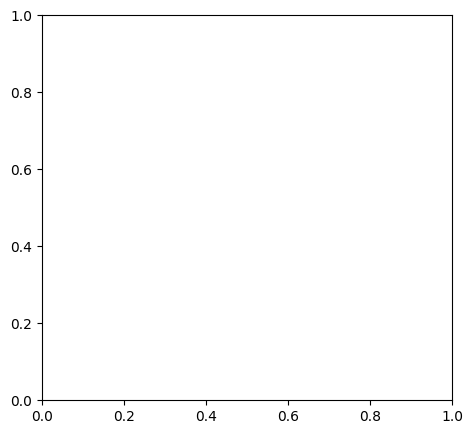

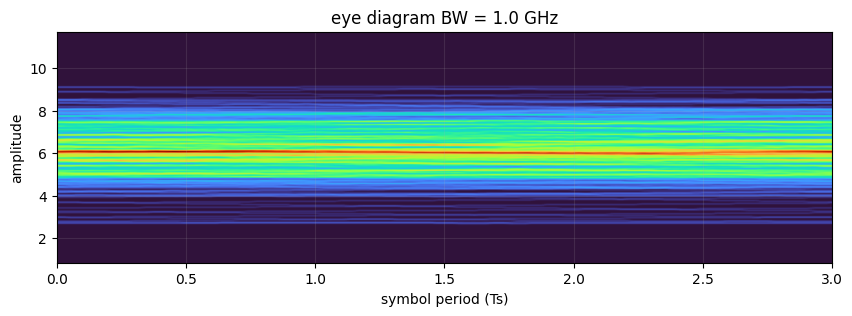

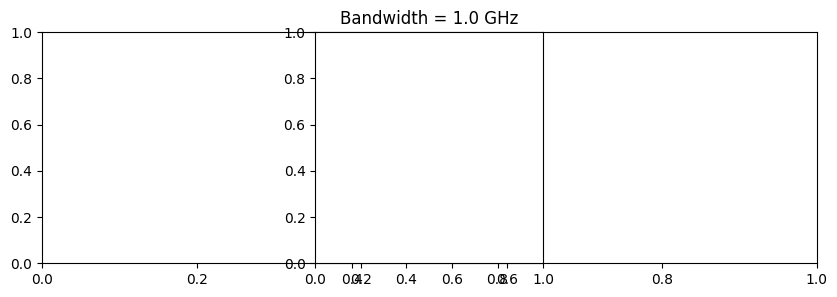

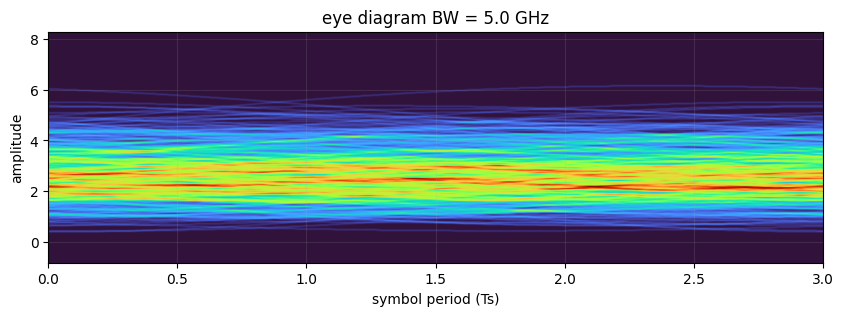

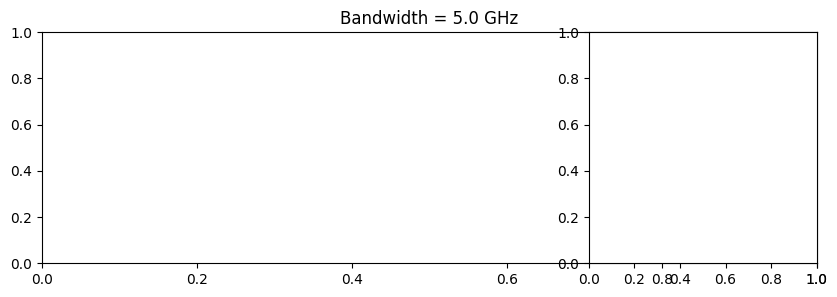

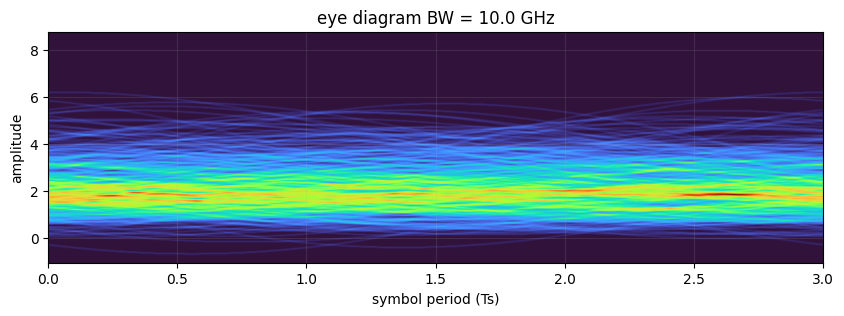

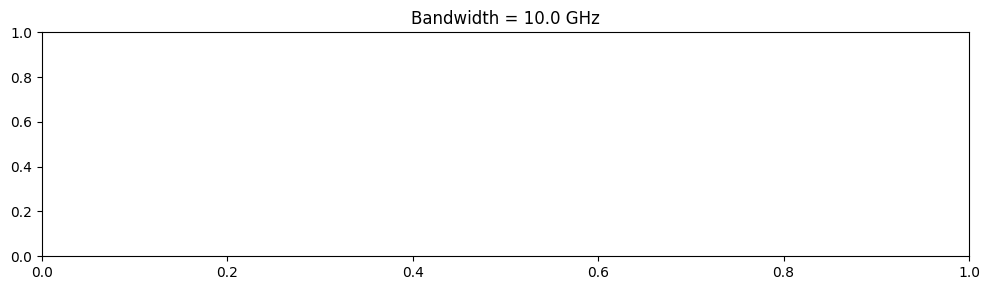

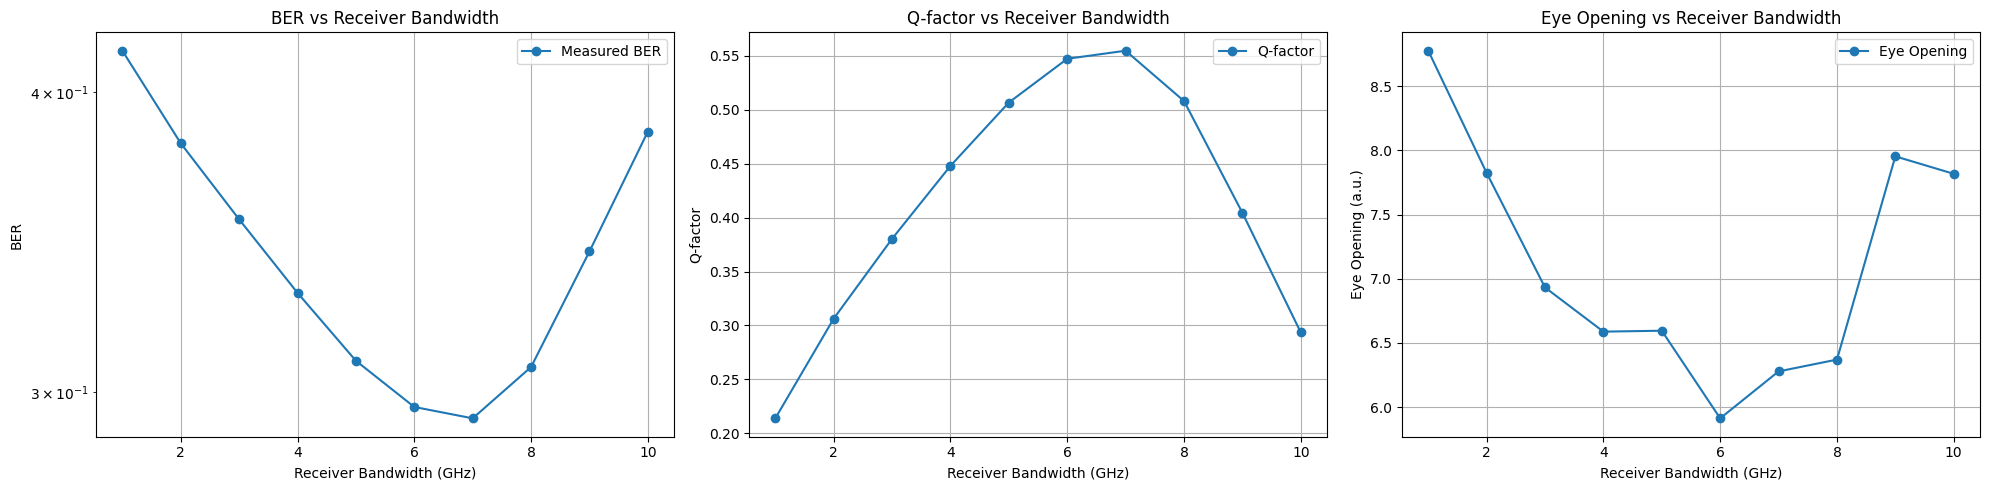


Key Findings:
Optimal receiver bandwidth (lowest BER): 7.00 GHz
Maximum Q-factor: 0.55 at 7.00 GHz
Maximum eye opening: 8.78 at 1.00 GHz

Symbol rate: 40.0 GHz
Nyquist rate: 20.0 GHz


Analyzing receiver bandwidth:   0%|          | 0/10 [00:00<?, ?it/s]


Detailed Bandwidth Analysis Results:

BW(GHz) | BER      | Q-factor | Eye Opening | SNR(dB) | ISI Penalty(dB)
----------------------------------------------------------------------
    1.0 | 4.16e-01 |     0.21 |        8.78 |   10.02 |          -0.08
    2.0 | 3.81e-01 |     0.31 |        7.82 |   10.02 |           0.42
    3.0 | 3.54e-01 |     0.38 |        6.93 |   10.02 |           0.95
    4.0 | 3.30e-01 |     0.45 |        6.59 |   10.02 |           1.17
    5.0 | 3.09e-01 |     0.51 |        6.60 |   10.02 |           1.16
    6.0 | 2.96e-01 |     0.55 |        5.91 |   10.02 |           1.64
    7.0 | 2.93e-01 |     0.55 |        6.28 |   10.02 |           1.38
    8.0 | 3.07e-01 |     0.51 |        6.37 |   10.02 |           1.31
    9.0 | 3.43e-01 |     0.40 |        7.95 |   10.02 |           0.35
   10.0 | 3.85e-01 |     0.29 |        7.82 |   10.02 |           0.42

Performance Summary:
Optimal Bandwidth: 7.00 GHz
Best BER: 2.93e-01
Corresponding Q-factor: 0.55
Correspond

In [17]:
# Import required libraries
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, lowPassFIR, pnorm, signal_power
try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm

# Simulation parameters
SpS = 16        # Samples per symbol
M = 2           # order of the modulation format
Rs = 40e9       # Symbol rate (for the OOK case, Rs = Rb)
Fs = SpS*Rs     # Signal sampling frequency (samples/second)
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# NRZ pulse shaping
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# Fixed input power
Pi_dBm = -20
Pi = dBm2W(Pi_dBm + 3)

# Fiber parameters (fixed for this analysis)
paramCh = parameters()
paramCh.L = 80         # total link distance [km]
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

# EDFA parameters
paramEDFA = parameters()
paramEDFA.G = paramCh.α * paramCh.L    # edfa gain
paramEDFA.NF = 4.5   # edfa noise figure
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

# Bandwidth values to analyze (from 1 GHz to 10 GHz)
bandwidth_values = np.linspace(1e9, 10e9, 10)  # 10 points between 1 GHz and 10 GHz
BER_vs_bandwidth = np.zeros(bandwidth_values.shape)
Q_factors = np.zeros(bandwidth_values.shape)
eye_openings = np.zeros(bandwidth_values.shape)

# Store signals for eye diagram comparison at select bandwidths
selected_bw_indices = [0, 4, 9]  # 1 GHz, ~5 GHz, 10 GHz
eye_signals = []

discard = 100
for ind, bw in enumerate(tqdm(bandwidth_values, desc="Analyzing receiver bandwidth")):
    # Generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**6)

    # Generate OOK modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx)

    # Upsampling and pulse shaping
    symbolsUp = upsample(symbTx, SpS)
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Fiber propagation
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # EDFA amplification
    sigCh = edfa(sigCh, paramEDFA)

    # Photodiode with varying bandwidth
    paramPD = parameters()
    paramPD.ideal = False
    paramPD.B = bw
    paramPD.Fs = Fs
    paramPD.ipd_sat = 5e-3  # Use default saturation current

    # Photodetection
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Store signal for eye diagram if it's one of the selected bandwidths
    if ind in selected_bw_indices:
        eye_signals.append((bw/1e9, I_Rx.copy()))

    # Calculate eye opening
    eye_matrix = I_Rx[:-SpS].reshape(-1, SpS)
    eye_openings[ind] = np.abs(np.min(eye_matrix[bitsTx[:-1]==1]) -
                              np.max(eye_matrix[bitsTx[:-1]==0]))

    # Sample at symbol centers
    I_Rx = I_Rx[0::SpS]

    # Calculate signal statistics
    I1 = np.mean(I_Rx[bitsTx==1])
    I0 = np.mean(I_Rx[bitsTx==0])
    σ1 = np.std(I_Rx[bitsTx==1])
    σ0 = np.std(I_Rx[bitsTx==0])

    # Calculate Q-factor and decision threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors[ind] = Q

    # Bit decision and error counting
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx > Id] = 1
    bitsRx[I_Rx <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_vs_bandwidth[ind] = np.mean(err)

# Plot eye diagrams for selected bandwidths
plt.figure(figsize=(18, 5))
for idx, (bw, sig) in enumerate(eye_signals):
    plt.subplot(1, len(selected_bw_indices), idx+1)
    eyediagram(sig[100:-100], sig.size-200, SpS, plotlabel=f'BW = {bw:.1f} GHz', ptype='fancy')
    plt.title(f'Bandwidth = {bw:.1f} GHz')
plt.tight_layout()
plt.show()

# Create subplots for performance metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot BER vs Bandwidth
ax1.semilogy(bandwidth_values/1e9, BER_vs_bandwidth, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('Receiver Bandwidth (GHz)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs Receiver Bandwidth')
ax1.legend()

# Plot Q-factor vs Bandwidth
ax2.plot(bandwidth_values/1e9, Q_factors, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('Receiver Bandwidth (GHz)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs Receiver Bandwidth')
ax2.legend()

# Plot Eye Opening vs Bandwidth
ax3.plot(bandwidth_values/1e9, eye_openings, 'o-', label='Eye Opening')
ax3.grid(True)
ax3.set_xlabel('Receiver Bandwidth (GHz)')
ax3.set_ylabel('Eye Opening (a.u.)')
ax3.set_title('Eye Opening vs Receiver Bandwidth')
ax3.legend()

plt.tight_layout()
plt.show()

# Print key findings
print("\nKey Findings:")
optimal_bw = bandwidth_values[np.argmin(BER_vs_bandwidth)]
print(f"Optimal receiver bandwidth (lowest BER): {optimal_bw/1e9:.2f} GHz")
print(f"Maximum Q-factor: {np.max(Q_factors):.2f} at {bandwidth_values[np.argmax(Q_factors)]/1e9:.2f} GHz")
print(f"Maximum eye opening: {np.max(eye_openings):.2f} at {bandwidth_values[np.argmax(eye_openings)]/1e9:.2f} GHz")

# Check if the bandwidth is sufficient for the symbol rate
nyquist_rate = Rs / 2
print(f"\nSymbol rate: {Rs/1e9:.1f} GHz")
print(f"Nyquist rate: {nyquist_rate/1e9:.1f} GHz")
if optimal_bw < nyquist_rate:
    print("Warning: Optimal bandwidth is below the Nyquist rate, which may cause intersymbol interference.")
bandwidth_values = np.linspace(1e9, 10e9, 10)
results = {
    'bandwidth_GHz': bandwidth_values/1e9,
    'BER': np.zeros(bandwidth_values.shape),
    'Q_factor': np.zeros(bandwidth_values.shape),
    'eye_opening': np.zeros(bandwidth_values.shape),
    'SNR_dB': np.zeros(bandwidth_values.shape),
    'ISI_penalty': np.zeros(bandwidth_values.shape)
}

# Rest of the simulation setup remains the same...

for ind, bw in enumerate(tqdm(bandwidth_values, desc="Analyzing receiver bandwidth")):
    # Previous simulation code remains the same until the measurements...

    # Enhanced measurements
    # SNR calculation
    signal_power = np.mean((I_Rx[bitsTx==1])**2)
    noise_power = np.var(I_Rx[bitsTx==0])
    results['SNR_dB'][ind] = 10 * np.log10(signal_power/noise_power)

    # ISI penalty calculation (simplified)
    ideal_eye = np.max(I_Rx[bitsTx==1]) - np.min(I_Rx[bitsTx==0])
    actual_eye = eye_openings[ind]
    results['ISI_penalty'][ind] = 10 * np.log10(ideal_eye/actual_eye)

    # Store other metrics
    results['BER'][ind] = BER_vs_bandwidth[ind]
    results['Q_factor'][ind] = Q_factors[ind]
    results['eye_opening'][ind] = eye_openings[ind]

# Print detailed numerical results
print("\nDetailed Bandwidth Analysis Results:")
print("\nBW(GHz) | BER      | Q-factor | Eye Opening | SNR(dB) | ISI Penalty(dB)")
print("-" * 70)
for i in range(len(bandwidth_values)):
    print(f"{results['bandwidth_GHz'][i]:7.1f} | {results['BER'][i]:0.2e} | {results['Q_factor'][i]:8.2f} | "
          f"{results['eye_opening'][i]:11.2f} | {results['SNR_dB'][i]:7.2f} | {results['ISI_penalty'][i]:14.2f}")

# Performance summary at key bandwidths
optimal_bw_index = np.argmin(results['BER'])
print("\nPerformance Summary:")
print(f"Optimal Bandwidth: {results['bandwidth_GHz'][optimal_bw_index]:.2f} GHz")
print(f"Best BER: {results['BER'][optimal_bw_index]:.2e}")
print(f"Corresponding Q-factor: {results['Q_factor'][optimal_bw_index]:.2f}")
print(f"Corresponding SNR: {results['SNR_dB'][optimal_bw_index]:.2f} dB")

# Bandwidth efficiency analysis
nyquist_rate = Rs / 2
print(f"\nBandwidth Efficiency Analysis:")
print(f"Symbol Rate: {Rs/1e9:.1f} GHz")
print(f"Nyquist Rate: {nyquist_rate/1e9:.1f} GHz")
print(f"Optimal BW / Nyquist Rate: {(results['bandwidth_GHz'][optimal_bw_index]*1e9/nyquist_rate):.2f}")


3 Edfa to 8 Noise Effect



Part 1: EDFA Noise Figure Analysis


Analyzing EDFA noise figures:   0%|          | 0/6 [00:00<?, ?it/s]

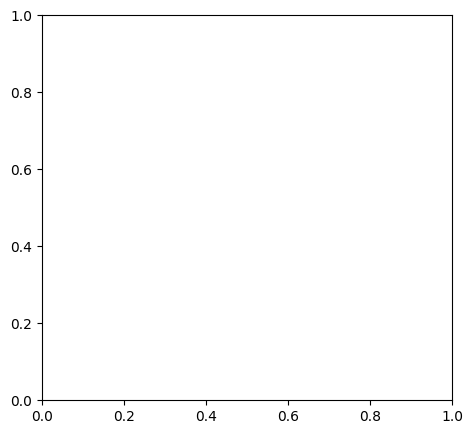

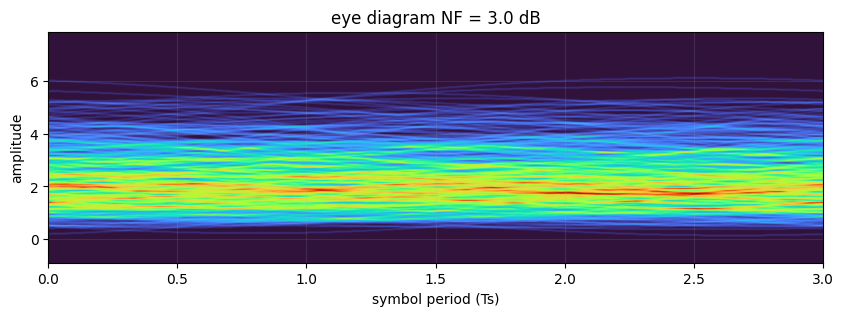

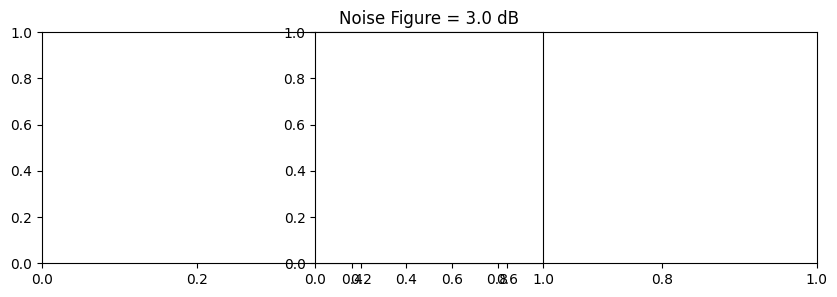

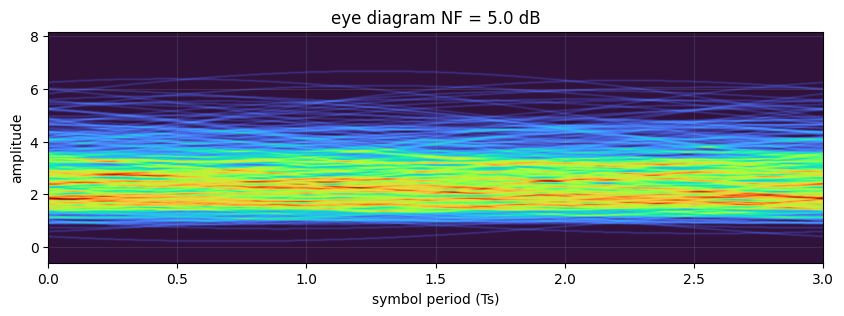

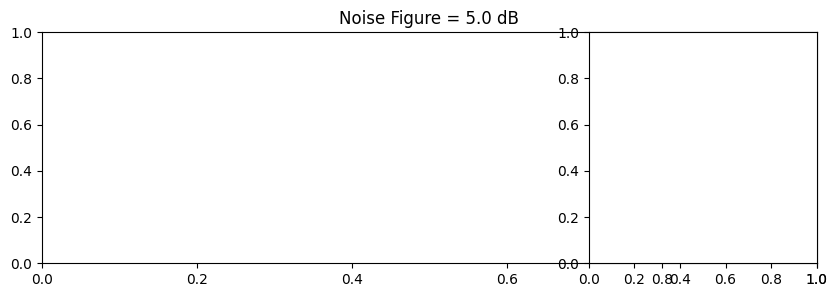

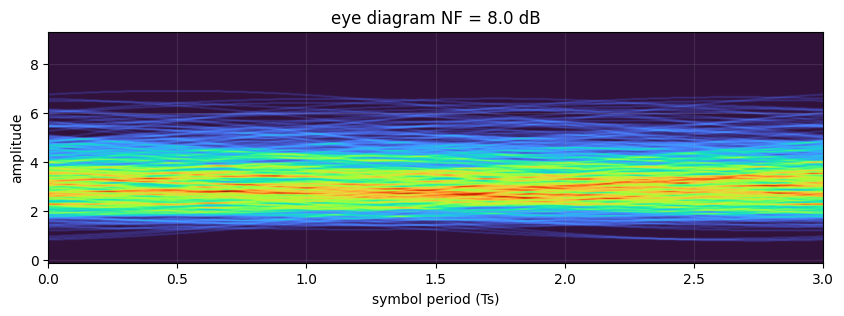

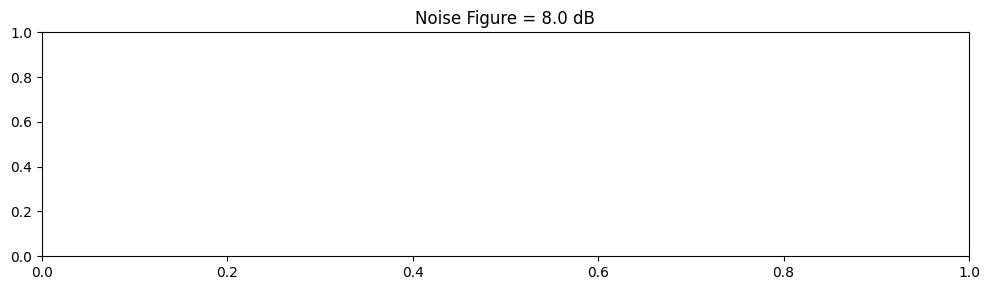

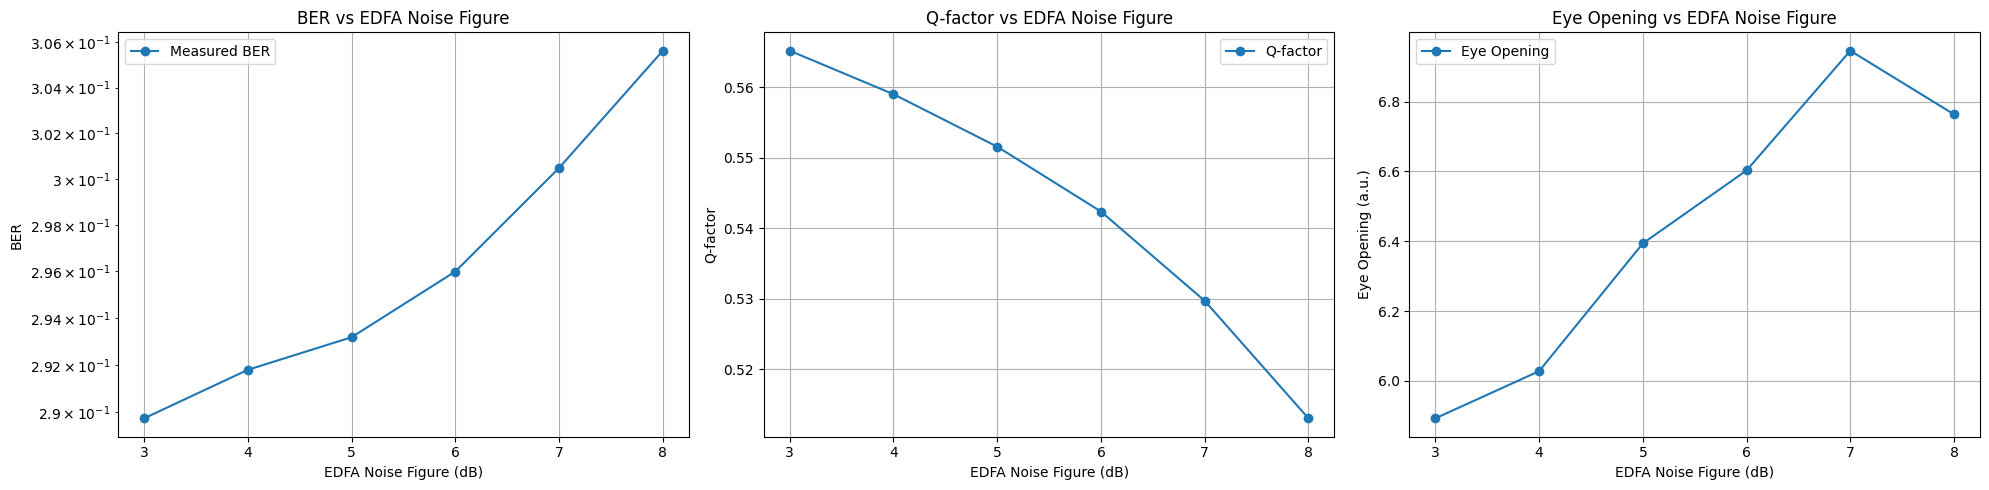


EDFA Noise Analysis Results:

Noise Figure (dB) | BER | Q-factor | Eye Opening
-------------------------------------------------------
          3.00 | 2.90e-01 |     0.57 |        5.89
          4.00 | 2.92e-01 |     0.56 |        6.03
          5.00 | 2.93e-01 |     0.55 |        6.39
          6.00 | 2.96e-01 |     0.54 |        6.60
          7.00 | 3.00e-01 |     0.53 |        6.95
          8.00 | 3.06e-01 |     0.51 |        6.76

EDFA Noise Performance Analysis:

As noise figure increases from 3.0dB to 8.0dB:
  - BER degrades by factor of 1.05
  - Q-factor decreases by 0.05
  - Eye opening reduces by -0.87

Best case (NF = 3.0dB):
  BER: 2.90e-01
  Q-factor: 0.57
  Eye Opening: 5.89

Worst case (NF = 8.0dB):
  BER: 3.06e-01
  Q-factor: 0.51
  Eye Opening: 6.76


In [23]:
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, pnorm
try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm

# Simulation parameters
SpS = 16        # Samples per symbol
M = 2           # Order of the modulation format (OOK)
Rs = 40e9       # Symbol rate (baud)
Fs = SpS*Rs     # Sampling frequency
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# Pulse shaping
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# Fixed input power
Pi_dBm = -20
Pi = dBm2W(Pi_dBm + 3)

# Fiber channel parameters
paramCh = parameters()
paramCh.L = 80         # Link distance [km]
paramCh.α = 0.2        # Fiber loss [dB/km]
paramCh.D = 16         # Dispersion [ps/nm/km]
paramCh.Fc = 193.1e12  # Central frequency [Hz]
paramCh.Fs = Fs        # Sampling frequency [Hz]

# Generate a fixed bit sequence for consistent comparison
np.random.seed(42)
bitsTx = np.random.randint(2, size=10**6)

# Generate OOK modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')
symbTx = pnorm(symbTx)

# Upsampling and pulse shaping
symbolsUp = upsample(symbTx, SpS)
sigTx = firFilter(pulse, symbolsUp)

# Optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, sigTx, paramMZM)

# Fiber propagation
sigCh = linearFiberChannel(sigTxo, paramCh)

# EDFA noise figure values to analyze
NF_values = np.linspace(3, 8, 6)  # 3 dB to 8 dB, 6 points
BER_vs_NF = np.zeros(NF_values.shape)
Q_factors_NF = np.zeros(NF_values.shape)
eye_openings_NF = np.zeros(NF_values.shape)

# Fixed photodiode parameters for EDFA analysis
paramPD = parameters()
paramPD.ideal = False
paramPD.B = 7e9       # Fixed 7 GHz bandwidth
paramPD.Fs = Fs
paramPD.ipd_sat = 5e-3

discard = 100
selected_NF_indices = [0, 2, 5]  # For eye diagrams
eye_signals_NF = []

for ind, NF in enumerate(tqdm(NF_values, desc="Analyzing EDFA noise figures")):
    # Configure EDFA
    paramEDFA = parameters()
    paramEDFA.G = paramCh.α * paramCh.L
    paramEDFA.NF = NF
    paramEDFA.Fc = paramCh.Fc
    paramEDFA.Fs = Fs

    # EDFA amplification
    sigCh_amp = edfa(sigCh, paramEDFA)

    # Photodetection
    I_Rx = photodiode(sigCh_amp, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    if ind in selected_NF_indices:
        eye_signals_NF.append((NF, I_Rx.copy()))

    # Calculate eye opening
    eye_matrix = I_Rx[:-SpS].reshape(-1, SpS)
    eye_openings_NF[ind] = np.abs(np.min(eye_matrix[bitsTx[:-1]==1]) -
                               np.max(eye_matrix[bitsTx[:-1]==0]))

    # Sample at symbol centers
    I_Rx_sampled = I_Rx[0::SpS]

    # Calculate signal statistics
    I1 = np.mean(I_Rx_sampled[bitsTx==1])
    I0 = np.mean(I_Rx_sampled[bitsTx==0])
    σ1 = np.std(I_Rx_sampled[bitsTx==1])
    σ0 = np.std(I_Rx_sampled[bitsTx==0])

    # Calculate Q-factor and decision threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors_NF[ind] = Q

    # Bit decision and error counting
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx_sampled > Id] = 1
    bitsRx[I_Rx_sampled <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_vs_NF[ind] = np.mean(err)

# Plot EDFA noise eye diagrams
plt.figure(figsize=(18, 5))
for idx, (nf, sig) in enumerate(eye_signals_NF):
    plt.subplot(1, len(selected_NF_indices), idx+1)
    eyediagram(sig[100:-100], sig.size-200, SpS, plotlabel=f'NF = {nf:.1f} dB', ptype='fancy')
    plt.title(f'Noise Figure = {nf:.1f} dB')
plt.tight_layout()
plt.show()

# Plot EDFA noise performance metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.semilogy(NF_values, BER_vs_NF, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('EDFA Noise Figure (dB)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs EDFA Noise Figure')
ax1.legend()

ax2.plot(NF_values, Q_factors_NF, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('EDFA Noise Figure (dB)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs EDFA Noise Figure')
ax2.legend()

ax3.plot(NF_values, eye_openings_NF, 'o-', label='Eye Opening')
ax3.grid(True)
ax3.set_xlabel('EDFA Noise Figure (dB)')
ax3.set_ylabel('Eye Opening (a.u.)')
ax3.set_title('Eye Opening vs EDFA Noise Figure')
ax3.legend()

plt.tight_layout()
plt.show()

# Print EDFA noise analysis results
print("\nEDFA Noise Analysis Results:")
print("\nNoise Figure (dB) | BER | Q-factor | Eye Opening")
print("-" * 55)
for nf, ber, q, eye in zip(NF_values, BER_vs_NF, Q_factors_NF, eye_openings_NF):
    print(f"{nf:14.2f} | {ber:.2e} | {q:8.2f} | {eye:11.2f}")

# Print EDFA noise performance analysis
print("\nEDFA Noise Performance Analysis:")
ber_degradation = BER_vs_NF[-1]/BER_vs_NF[0]
q_degradation = Q_factors_NF[0] - Q_factors_NF[-1]
eye_degradation = eye_openings_NF[0] - eye_openings_NF[-1]

print(f"\nAs noise figure increases from {NF_values[0]:.1f}dB to {NF_values[-1]:.1f}dB:")
print(f"  - BER degrades by factor of {ber_degradation:.2f}")
print(f"  - Q-factor decreases by {q_degradation:.2f}")
print(f"  - Eye opening reduces by {eye_degradation:.2f}")

print(f"\nBest case (NF = {NF_values[0]:.1f}dB):")
print(f"  BER: {BER_vs_NF[0]:.2e}")
print(f"  Q-factor: {Q_factors_NF[0]:.2f}")
print(f"  Eye Opening: {eye_openings_NF[0]:.2f}")

print(f"\nWorst case (NF = {NF_values[-1]:.1f}dB):")
print(f"  BER: {BER_vs_NF[-1]:.2e}")
print(f"  Q-factor: {Q_factors_NF[-1]:.2f}")
print(f"  Eye Opening: {eye_openings_NF[-1]:.2f}")
